## **Song Genre Predictor - Aarish Irfan**


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
nltk.download('punkt')

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/My Drive/lyrics.csv"
lyrics = pd.read_csv(path)

In [ ]:
lyrics.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [ ]:
lyrics.describe()

,index,year
count,362237.000000,362237.000000
mean,181118.000000,2008.537596
std,104568.959068,9.908024
min,0.000000,67.000000
25%,90559.000000,2006.000000
50%,181118.000000,2008.000000
75%,271677.000000,2014.000000
max,362236.000000,2038.000000


In [ ]:
lyrics.isnull().any()

index     False
song       True
year      False
artist    False
genre     False
lyrics     True
dtype: bool

In [ ]:
lyrics.isnull().sum()

index         0
song          2
year          0
artist        0
genre         0
lyrics    95680
dtype: int64

In [ ]:
# Removing null rows
songs = lyrics[lyrics['lyrics'].isnull() == False]
songs = songs[songs['song'].isnull() == False]

In [ ]:
songs.groupby('genre').size()

genre
Country           14387
Electronic         7966
Folk               2243
Hip-Hop           24850
Indie              3149
Jazz               7970
Metal             23759
Not Available     23941
Other              5189
Pop               40466
R&B                3401
Rock             109235
dtype: int64

In [ ]:
songs = songs[songs['genre'] != 'Not Available']
songs = songs[songs['genre'] != 'Other']

(array([ 40466.,  24850., 109235.,  23759.,  14387.,   7970.,   7966.,
          2243.,   3401.,   3149.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

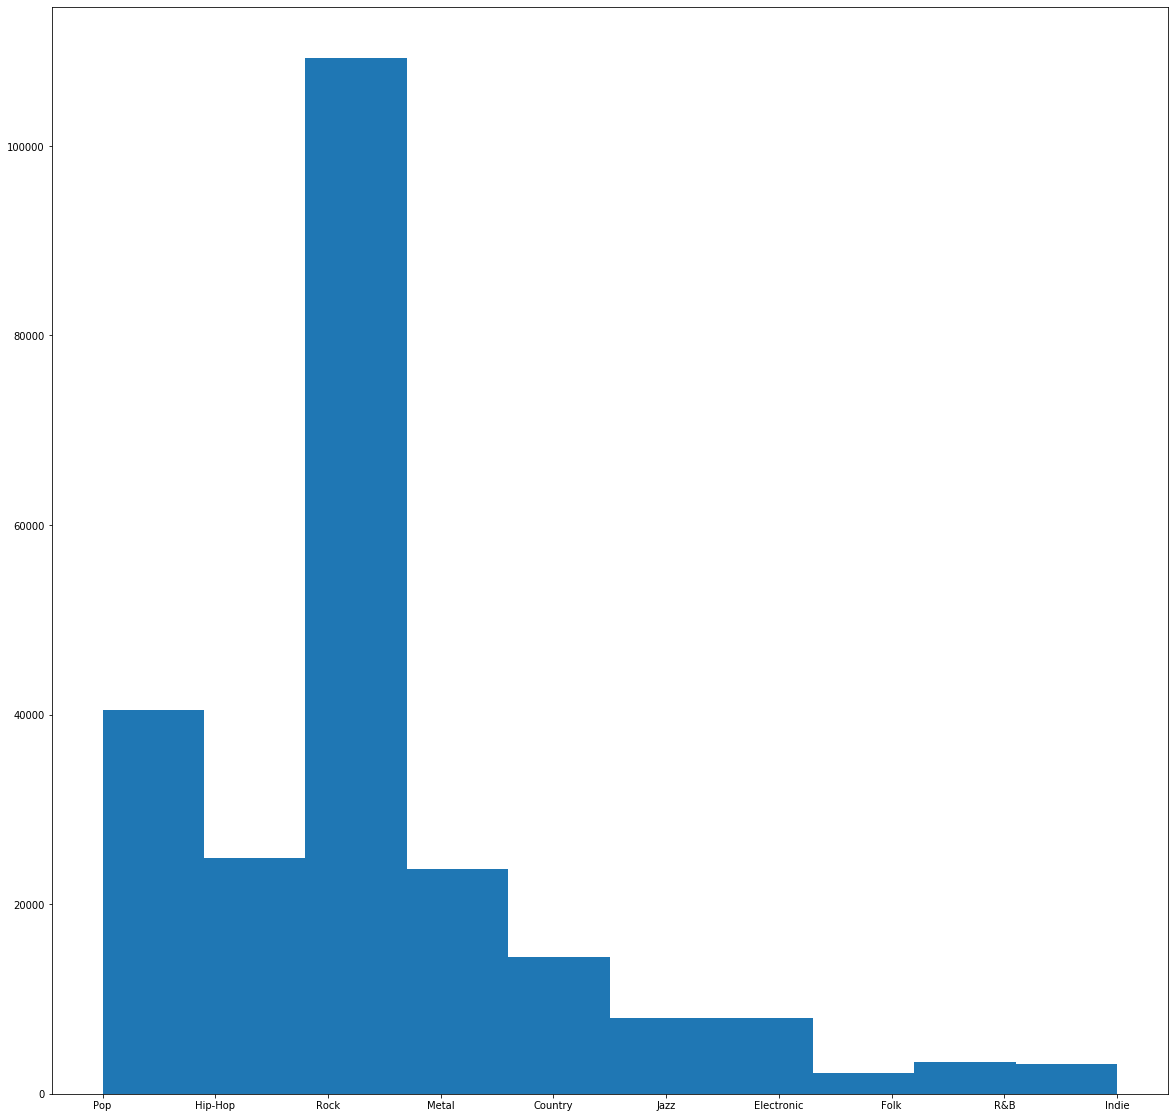

In [ ]:
plt.figure(figsize=[20,20])
plt.hist(songs['genre'])

In [ ]:
songs['length'] = songs['lyrics'].str.len()
songs.head()

,index,song,year,artist,genre,lyrics,length
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu...",1961
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see...",1270
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...,827
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...",2344
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po...",1540


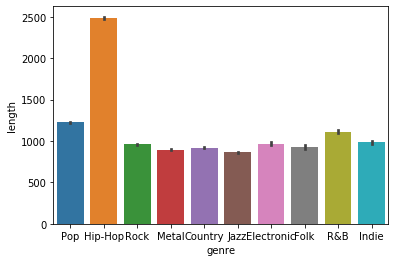

In [ ]:
sns.barplot(x='genre', y='length', data=songs)

In [ ]:
# Cleaning lyrics
def convert_to_lower_case(text): 
  return text.lower()

songs["lyrics"] = songs["lyrics"].apply(convert_to_lower_case)

punct_re = r'[^\w\s]'
songs['no_punc'] = songs['lyrics'].str.replace(punct_re, ' ')
songs['wo_newline'] = songs['no_punc'].str.replace('\n', '')

nltk.download('stopwords')
stop_words = list(((set(stopwords.words('english')))))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
songs_2010_2016 = songs[songs['year'] >= 2010]
final_songs_2010_16 = songs_2010_2016.loc[songs_2010_2016['length'] >= 100]

In [ ]:
pop_genres = final_songs_2010_16.loc[(final_songs_2010_16['genre'] == 'Pop') |
                                 (final_songs_2010_16['genre'] == 'Rock') |
                                 (final_songs_2010_16['genre'] == 'Metal') |
                                 (final_songs_2010_16['genre'] == 'Hip-Hop')]
new_df = pop_genres.loc[:, ['genre', 'length', 'wo_newline']]                              

In [ ]:
new_df.columns = ['genre', 'length', 'lyrics']
new_df.head()

,genre,length,lyrics
55,Pop,855,andre 3000 i i i left no time to regretkept...
56,Pop,4291,verse 1 beyonce i ve been watching for the s...
57,Pop,1773,verse 1 when the palm of my two hands hold ea...
58,Pop,2891,intro presenter the winner isbeyonce knowles...
59,Pop,2990,intro your challengers are a young group from...


In [ ]:
new_df['lyrics'] = new_df['lyrics'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))
new_df.head()

,genre,length,lyrics
55,Pop,855,andre 3000 left time regretkept dick wet old b...
56,Pop,4291,verse 1 beyonce watching signstook trip clear ...
57,Pop,1773,verse 1 palm two hands hold otherthat feels di...
58,Pop,2891,intro presenter winner isbeyonce knowles femal...
59,Pop,2990,intro challengers young group houstonwelcome b...


In [ ]:
lyric_pop = new_df[new_df['genre'] == 'Pop']['lyrics']
lyric_hiphop = new_df[new_df['genre'] == 'Hip-Hop']['lyrics']
lyric_rock = new_df[new_df['genre'] == 'Rock']['lyrics']
lyric_metal = new_df[new_df['genre'] == 'Metal']['lyrics']

In [ ]:
lyric_pop

55        andre 3000 left time regretkept dick wet old b...
56        verse 1 beyonce watching signstook trip clear ...
57        verse 1 palm two hands hold otherthat feels di...
58        intro presenter winner isbeyonce knowles femal...
59        intro challengers young group houstonwelcome b...
                                ...                        
362210    photographs taking noware taken againwhen heav...
362211    met moko jumbie walks stilts saints rowlooking...
362212    chill hollow pondsset sail kidin heat wave hit...
362213    celebrate passing drugsput back seat whilethey...
362214    serve doneand parish shuffled someand may freq...
Name: lyrics, Length: 14310, dtype: object

In [ ]:
common_pop = Counter(" ".join(lyric_pop).split()).most_common()

pop_common = []
for k, v in common_pop:
  if len(k) > 3:
    pop_common.append(k)
pop_100 = pop_common[:100]

In [ ]:
common_hiphop = Counter(" ".join(lyric_hiphop).split()).most_common()

hiphop_common = []
for k, v in common_hiphop:
  if len(k) > 3:
    hiphop_common.append(k)
hiphop_100 = hiphop_common[:100]

In [ ]:
common_rock = Counter(" ".join(lyric_rock).split()).most_common()

rock_common = []
for k, v in common_rock:
  if len(k) > 3:
    rock_common.append(k)
rock_100 = rock_common[:100]

In [ ]:
common_metal = Counter(" ".join(lyric_metal).split()).most_common()

metal_common = []
for k, v in common_metal:
  if len(k)> 3:
    metal_common.append(k)
metal_100 = metal_common[:100]

In [ ]:
without_pop = hiphop_100 + rock_100 + metal_100
unique_pop = []
for i in range(len(pop_common)):
  if pop_common[i] not in without_pop:
    unique_pop.append(pop_common[i])
unique_pop[:10]

['hands',
 'tonight',
 'wish',
 'kiss',
 'girls',
 'dance',
 'start',
 'ready',
 'crazy',
 'miss']

In [ ]:
without_hiphop = pop_100 + rock_100 + metal_100
unique_hiphop = []
for i in range(len(hiphop_common)):
  if hiphop_common[i] not in without_pop:
    unique_hiphop.append(hiphop_common[i])

unique_hiphop[:10]

['mean',
 'beat',
 'watch',
 'move',
 'first',
 'used',
 'everybody',
 'talking',
 'girls',
 'gettin']

In [ ]:
without_rock = hiphop_100 + pop_100 + metal_100
unique_rock = []
for i in range(len(rock_common)):
  if rock_common[i] not in without_rock:
    unique_rock.append(rock_common[i])
unique_rock[:10]


['well',
 'coming',
 'place',
 'comes',
 'wait',
 'hand',
 'found',
 'someone',
 'sing',
 'used']

In [ ]:
without_metal = hiphop_100 + pop_100 + rock_100
unique_metal = []
for i in range(len(metal_common)):
  if metal_common[i] not in without_metal:
    unique_metal.append(metal_common[i])
unique_metal[:10]

['blood',
 'dead',
 'death',
 'must',
 'hell',
 'soul',
 'pain',
 'fight',
 'fear',
 'hate']

In [ ]:
joined_hiphop = '|'.join(unique_hiphop[:10])
joined_metal = '|'.join(unique_metal[:10])
joined_pop = '|'.join(unique_pop[:10])
joined_rock = '|'.join(unique_rock[:10])

In [ ]:
new_df['hiphop'] = (new_df.loc[:, 'lyrics']).str.contains(joined_hiphop) * 1
new_df['metal'] = (new_df.loc[:, 'lyrics']).str.contains(joined_metal) * 1
new_df['pop'] = (new_df.loc[:, 'lyrics']).str.contains(joined_pop) * 1
new_df['rock'] = (new_df.loc[:, 'lyrics']).str.contains(joined_rock) * 1

In [ ]:
new_df.head()

,genre,length,lyrics,hiphop,metal,pop,rock
55,Pop,855,andre 3000 left time regretkept dick wet old b...,1,0,0,1
56,Pop,4291,verse 1 beyonce watching signstook trip clear ...,1,1,1,1
57,Pop,1773,verse 1 palm two hands hold otherthat feels di...,1,0,1,1
58,Pop,2891,intro presenter winner isbeyonce knowles femal...,1,1,1,1
59,Pop,2990,intro challengers young group houstonwelcome b...,1,1,1,1


In [ ]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
def polarity_calc(text):
  comp = sid.polarity_scores(text)
  return comp["compound"]

def polar(df):
    polars = []
    new_df = pd.DataFrame(df['lyrics'])
    for _, row in new_df.iterrows():
        p = polarity_calc(row.values[0])
        polars.append(p)
    return polars

In [ ]:
new_df['polarity'] = polar(new_df)

In [ ]:
new_df.head()

,genre,length,lyrics,hiphop,metal,pop,rock,polarity
55,Pop,855,andre 3000 left time regretkept dick wet old b...,1,0,0,1,-0.4939
56,Pop,4291,verse 1 beyonce watching signstook trip clear ...,1,1,1,1,0.9971
57,Pop,1773,verse 1 palm two hands hold otherthat feels di...,1,0,1,1,0.9711
58,Pop,2891,intro presenter winner isbeyonce knowles femal...,1,1,1,1,-0.8402
59,Pop,2990,intro challengers young group houstonwelcome b...,1,1,1,1,0.9928


In [ ]:
random_pop = new_df[new_df['genre'] == 'Pop'].sample(2500)
random_rock = new_df[new_df['genre'] == 'Rock'].sample(2500)
random_metal = new_df[new_df['genre'] == 'Metal'].sample(2500)
random_hiphop = new_df[new_df['genre'] == 'Hip-Hop'].sample(2500)

In [ ]:
final_df = random_pop.append(random_rock).append(random_hiphop).append(random_metal)

In [ ]:
def baseline_model():
  model = Sequential()
  model.add(Dense(6, input_dim=6, activation='relu'))
  model.add(Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
X = final_df.loc[:, ['length', 'hiphop', 'metal', 'pop', 'rock', 'polarity']]
X_normal = preprocessing.normalize(X)
y = final_df.loc[:, 'genre']

In [ ]:
# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X_normal, y, test_size = 0.25, random_state = 21)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y = encoder.transform(y_train)
dummy_y = np_utils.to_categorical(encoded_y)

In [ ]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)
kfold = KFold(n_splits=3, shuffle=True)

In [ ]:
# Nueral Network model with our featured dataset.
results = cross_val_score(estimator, X_train, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Baseline: 29.92% (4.87%)


In [ ]:
# RandomForestClassifier model with our featured dataset.
forest = RandomForestClassifier(n_estimators=100, random_state=1)
classifier = MultiOutputClassifier(forest, n_jobs=-1)
classifier.fit(X_train, dummy_y)
y_pred_rf = classifier.predict(X_test)

In [ ]:
# One-Hot Encoding test set.
encoded_y_test = encoder.transform(y_test)
dummy_y_test = np_utils.to_categorical(encoded_y_test)

In [ ]:
# Function to get random forest accuracy
def rf_acc(test, pred):
  num = len(test)
  t = pd.DataFrame(test)
  p  = pd.DataFrame(pred)
  correct = 0
  for i in range(num):
    if (t.iloc[i, :] == p.iloc[i, :]).all():
      correct += 1
  return correct / num

In [ ]:
rf_acc(dummy_y_test, y_pred_rf)

0.3128

In [ ]:
# tf-idf Vectorization
vectorizer = TfidfVectorizer()
tf_vec = vectorizer.fit_transform(final_df['lyrics'])

In [ ]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(tf_vec, y, test_size = 0.25, random_state = 21)
encoder.fit(y_train_tf)
encoded_y_train_tf = encoder.transform(y_train_tf)
dummy_y_train_tf = np_utils.to_categorical(encoded_y_train_tf)

encoded_y_test_tf = encoder.transform(y_test_tf)
dummy_y_test_tf = np_utils.to_categorical(encoded_y_test_tf)

In [ ]:
# Random Forest Model with only tf-idf Vectorization
rf = RandomForestClassifier()
rf.fit(X_train_tf, y_train_tf)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rf_acc(np.array(y_test_tf), rf.predict(X_test_tf))

0.5484